<a href="https://colab.research.google.com/github/gmehra123/data_science_projs/blob/main/Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Computer Vision

### Introduction

* If it uses images it is a computer vision problem
* Binary clasiification (steak or pizza)
* Multi class classification (Identify different foods and show calorie content)
* Object detection
* Computational photography: Identify different parts of an image

In [2]:
what_we_will_do = {'01': 'Get a dataset from torchvision.datasets',
                   '02':'Architecture of CNN',
                   '03': 'End to end multiclass classification problem',
                   '04': 'Discuss modelling workflow for computervision problems'}

### Inputs and outputs of CV
* W * H * C (Width, Height abd Color channel). sometimes batch size precedes this and the dimension becomes batch * Width * Height * Color channel
* Classification problems would create an output with columns equal to number of classes


**What is a CNN**
> Convulutional Neural networks use a moving window to convolve or move over the image detecting features. This converts the input into a set of numbers. Typical architecture involves a convolutional layer followed by a non linear activation followed by a pooling layer to reduce the dimensionality of the data


### Computer Vision libraries
See reference notebook: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/video_notebooks/03_pytorch_computer_vision_video.ipynb

* `torchvision` base library for vision problems
* `torchvision.datasets` some vision datasets
* `torchvision.transforms` manipulate vision data
* `torchvision.models` pre-trained models
* `torch.utils.data.Dataset` Base dataset class (create your own datasets)
* `torch.utils.data.DataLoader` Creates a python iterable over a dataset


In [36]:
import torch
import torch.nn as nn

# torchvision libraries and packages
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

In [37]:
## 1. Getting a datset (Fashion MNIST)
train_data = datasets.FashionMNIST(root="data",
                                   train=True, # training version of the dataset
                                   download=True, # do we want to download
                                   transform = ToTensor(), # convert to tensor
                                   target_transform = None, # No label transformation
                                   )


In [9]:
test_data = datasets.FashionMNIST(root="data",
                                  train=False,
                                  download=True,
                                  transform = ToTensor(),
                                  target_transform = None
                                  )

In [10]:
len(train_data) , len(test_data)

(60000, 10000)

In [11]:
image, label = train_data[0]

In [14]:
class_names = train_data.classes

In [16]:
class_to_idx = train_data.class_to_idx

In [38]:
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [41]:
image.shape, label

(torch.Size([1, 28, 28]), 6)

### Getting the input and output shapes of the data
* The images are 28 X 28 and are grayscale so color channel is 1.
* Since PyTorch puts color channel first the input chape is `[1,28,28]`
* Also since `torch` processes in batches the batch dimension comes first so `[None,1,28,28]` is the final input dimension
* Since the number of classes is 10 the output dimension is `[10]`

In [19]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Image of Ankle boot')

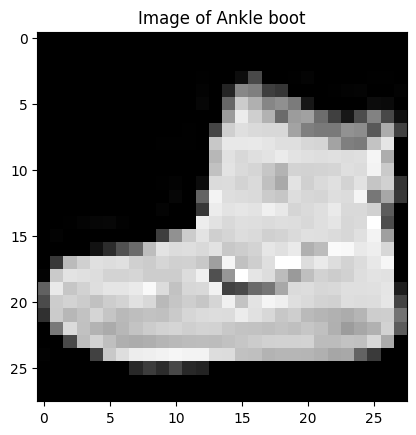

In [22]:
image,label = train_data[0]
# Matplotlib expects
plt.imshow(image.squeeze(),cmap='gray')
plt.title(f'Image of {class_names[label]}')

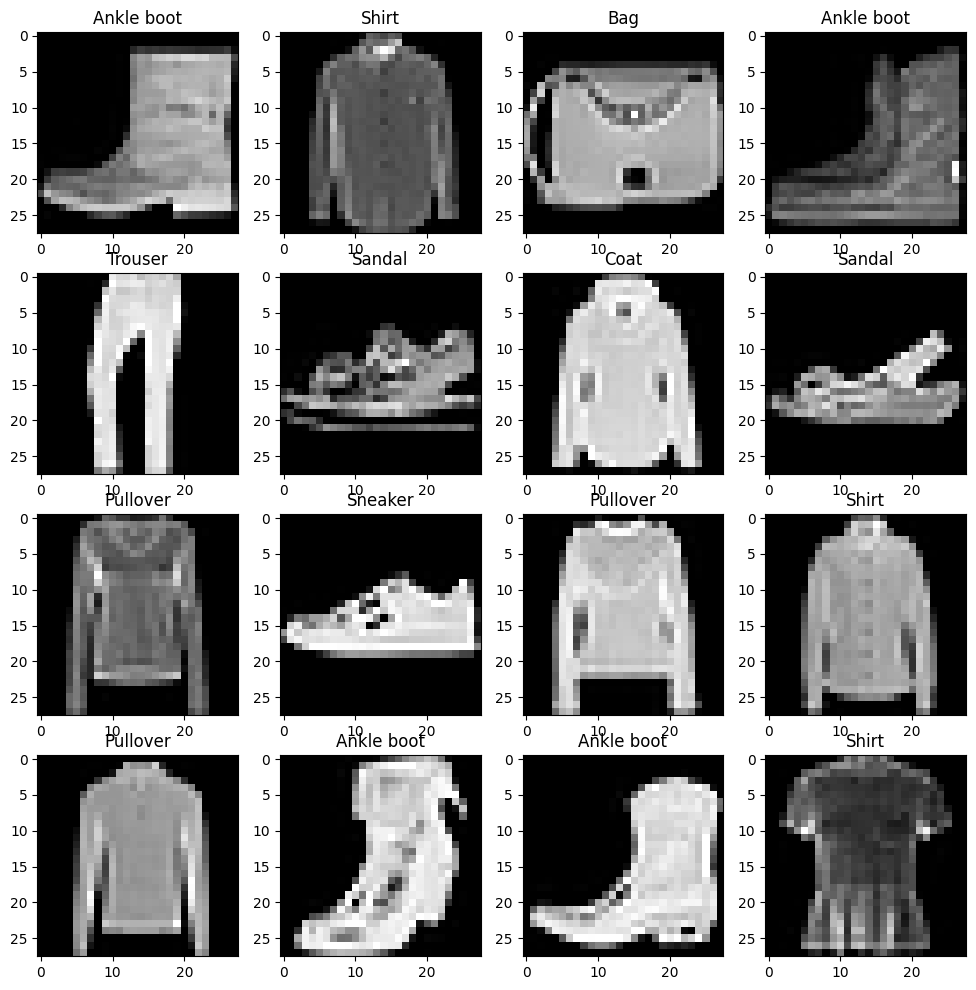

In [28]:
torch.manual_seed(42)
fig = plt.figure(figsize=(12,12))
rows,cols = 4,4
for i in range(1,rows*cols+1):
  rand_idx = torch.randint(0,len(train_data),size=[1]).item()
  img,label = train_data[rand_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.squeeze(),cmap='gray')
  plt.title(f"{class_names[label]}")

> Can we just use a linear model and lines to make accurate classification predictions on this data. If we look at the images, especially the images of boots and dresses, their edges are curved. This intuitively means that a linear model will not acurately capture the reality of these images

### Preparing data loaders
* A dataloader turns our data into a python iterable.
* Right now we are using the entire tensor dataset, in this case it is small and will probably work.
* However with larger datasets, it is best paractice to turn them into data-loaders, the first step is breaking data into mini batches

Why do it?
* Computattionally expensive
* Gives our neural network more chances to update its gradients per epoch (batch size = 32) **mini batch gradient descent**

In [29]:
from torch.utils.data import DataLoader

train_data_loader = DataLoader(dataset = train_data, # the datastet
                               batch_size=32, # the batchsize
                               shuffle=True # shuffle just in case the dataset has an implied order
                               )

test_data_loader = DataLoader(dataset=test_data,
                              batch_size = 32,
                              shuffle = False
                              )
train_data_loader, test_data_loader

(<torch.utils.data.dataloader.DataLoader at 0x7e7ceece92d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e7ceece88e0>)

In [34]:
print(f"dataloaders: {train_data_loader,test_data_loader}")
print(f"No of batches train,test:{len(train_data_loader),len(test_data_loader)}")

dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7e7ceece92d0>, <torch.utils.data.dataloader.DataLoader object at 0x7e7ceece88e0>)
No of batches train,test:(1875, 313)


In [35]:
train_features_batch,train_labels_batch = next(iter(train_data_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Text(0.5, 1.0, 'Pullover')

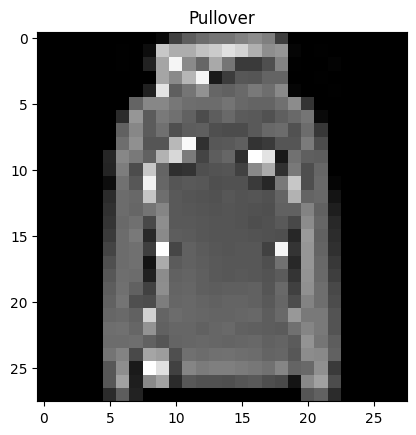

In [50]:
rand_idx = torch.randint(0,len(train_features_batch),size=[1]).item()
img,label = train_features_batch[rand_idx], train_labels_batch[rand_idx]
plt.imshow(img.squeeze(),cmap='gray')
plt.title(f"{class_names[label]}")

### Build a baseline model
Its a simple model that you will try and improve on with each iteration.

It is best practice to start simple and then add complexity as needed. This means that experiment tracking becomes crucial.

A new layer called flatten layer. Flatten converts C X W X H into C X Combined_dim where the combined dim is W*H in the case of FashionMNIST it is `[1,784]`

In [59]:
x=train_features_batch[0]
flatten = nn.Flatten()
x1 = flatten(x)
x1.shape

torch.Size([1, 784])

In [62]:
class CV_01(nn.Module):
  def __init__(self,
               input_shape: int,
               output_shape: int,
               hidden_units:int
               ):
    super().__init__()
    self.linear_stack = nn.Sequential(nn.Flatten(),
                                      nn.Linear(in_features=input_shape,out_features=hidden_units),
                                      nn.Linear(in_features=hidden_units,out_features=output_shape)
                                      )
  def forward(self,X):
    X = self.linear_stack(X)
    return X


In [63]:
model_0 = CV_01(784,10,8)

In [65]:
x=train_features_batch[0]
op=model_0(x)

In [68]:
dummy_x = torch.rand(size=[1,28,28])

In [73]:
flatten=nn.Flatten()
flatten(dummy_x)

tensor([[3.1096e-01, 5.3907e-01, 8.7604e-01, 6.6302e-01, 1.9105e-01, 8.0191e-01,
         3.1586e-01, 6.2895e-01, 5.2944e-01, 8.5709e-01, 3.8832e-01, 2.9684e-01,
         4.0040e-01, 5.0454e-01, 2.6404e-01, 8.4366e-01, 2.3193e-01, 5.7910e-01,
         1.1611e-01, 4.3792e-01, 3.9227e-01, 2.9997e-01, 7.6138e-01, 5.3545e-02,
         5.5244e-01, 4.5323e-01, 2.3996e-01, 8.8883e-01, 8.1388e-01, 6.5110e-01,
         5.0973e-01, 7.7713e-01, 2.8037e-01, 9.3133e-02, 9.7980e-01, 3.1283e-01,
         6.0030e-01, 5.0999e-01, 9.2093e-01, 9.9734e-01, 1.6360e-01, 4.9467e-01,
         9.4641e-02, 8.2294e-01, 9.7739e-01, 3.0888e-01, 5.9062e-01, 3.8991e-01,
         3.7887e-01, 8.9702e-01, 3.5438e-02, 4.3153e-01, 4.9795e-01, 5.9016e-02,
         7.0560e-01, 8.3343e-01, 1.0282e-01, 6.9346e-01, 4.6765e-01, 9.6844e-01,
         2.8815e-02, 9.2449e-01, 3.1425e-01, 9.2149e-01, 2.4495e-01, 5.8469e-01,
         6.1664e-01, 8.1019e-01, 7.3435e-01, 7.7943e-01, 3.9475e-01, 1.0442e-01,
         5.0581e-01, 9.5606e